<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-outliers/blob/SARIMA-Building/SARIMA_monthly_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Initial Dataset

In [ ]:
!pip install numpy==1.26.4 pmdarima==2.0.4

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [ ]:
url = "streamflow_filled_ARIMA.csv"
df = pd.read_csv(url)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()
df = df[["Q (m3/s)"]].rename(columns={"Q (m3/s)": "Q_m3_s"})
print(df.head(), df.shape)

            Q_m3_s
Date              
1967-01-01  2690.0
1967-01-02  2650.0
1967-01-03  2650.0
1967-01-04  2610.0
1967-01-05  2570.0 (18628, 1)


# Setting Up Monthly Datasets

In [17]:
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="MS") #Month Start
df_month_start = df.reindex(full_idx)

In [ ]:
df_month_sum = df.resample('ME').agg({
    'Q_m3_s': 'sum',})

In [ ]:
df_month_avg = df.resample('ME').agg({
    'Q_m3_s': 'mean'
})

# Plotting Datasets

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1967-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q_m3_s  612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


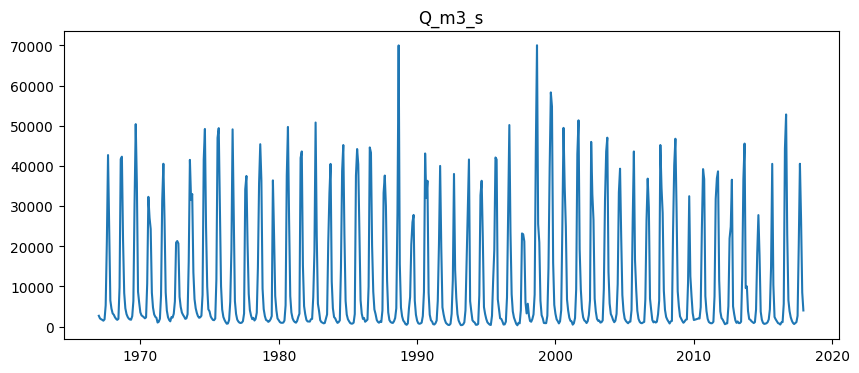

In [18]:
df_month_start.info()

plt.figure(figsize=(10,4))
plt.plot(df_month_start.index, df_month_start["Q_m3_s"])
plt.title("Q_m3_s")
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1967-01-31 to 2017-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q_m3_s  612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


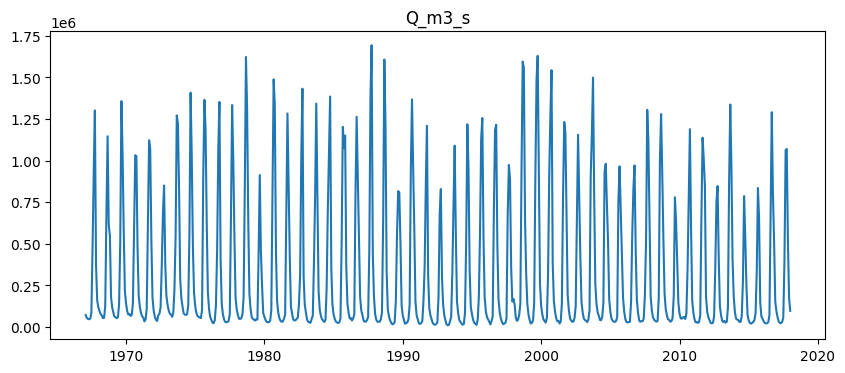

In [19]:
df_month_sum.info()

plt.figure(figsize=(10,4))
plt.plot(df_month_sum.index, df_month_sum["Q_m3_s"])
plt.title("Q_m3_s")
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1967-01-31 to 2017-12-31
Freq: ME
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Q_m3_s  612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


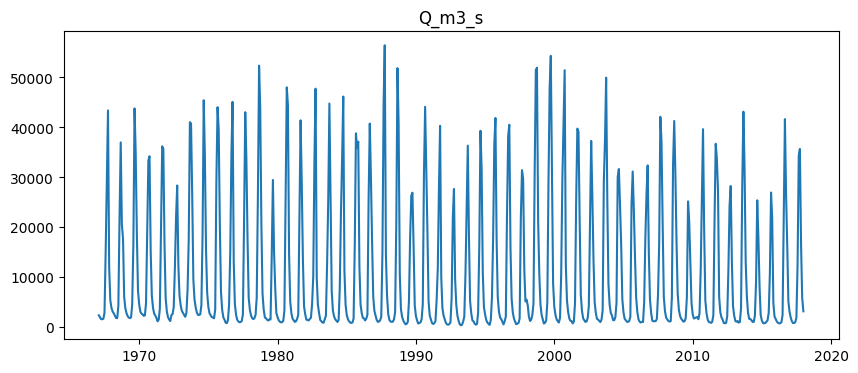

In [20]:
df_month_avg.info()

plt.figure(figsize=(10,4))
plt.plot(df_month_avg.index, df_month_avg["Q_m3_s"])
plt.title("Q_m3_s")
plt.show()

# Seasonal Decomposition

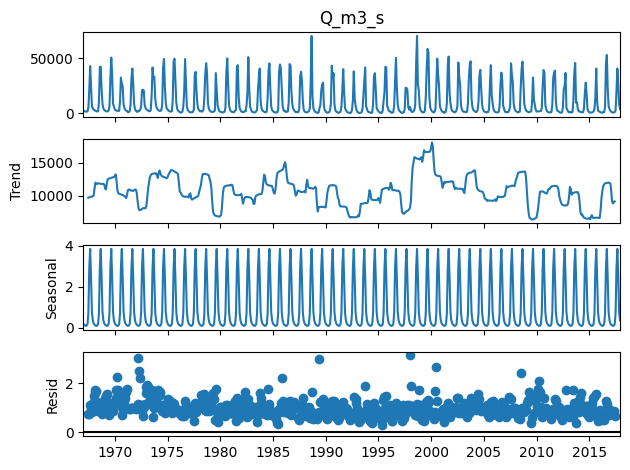

In [21]:
decomp = seasonal_decompose(df_month_start["Q_m3_s"], model="multiplicative", period=12)
decomp.plot()
plt.show()

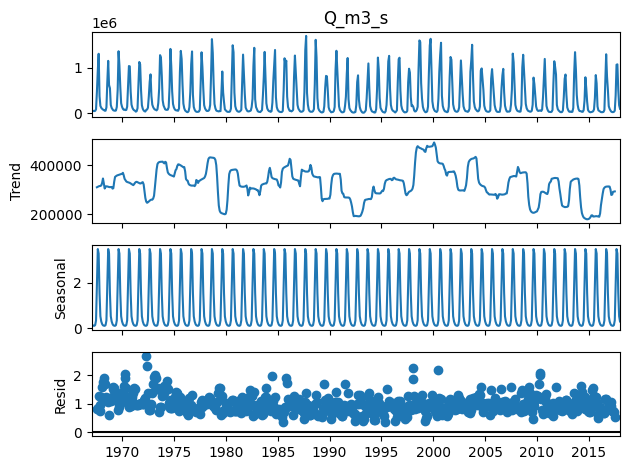

In [22]:
decomp = seasonal_decompose(df_month_sum["Q_m3_s"], model="multiplicative", period=12)
decomp.plot()
plt.show()

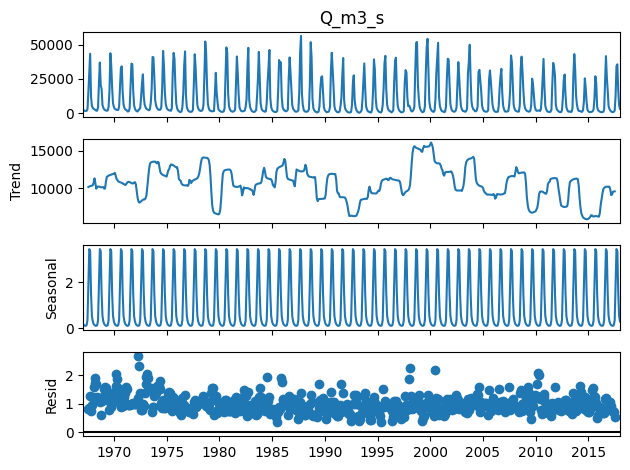

In [23]:
decomp = seasonal_decompose(df_month_avg["Q_m3_s"], model="multiplicative", period=12)
decomp.plot()
plt.show()

# ACF/PACF

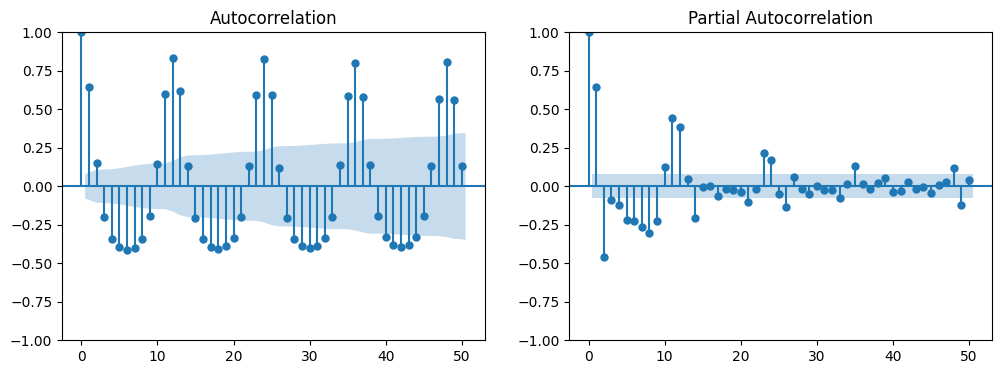

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df_month_start["Q_m3_s"], ax=ax[0], lags=50)
plot_pacf(df_month_start["Q_m3_s"], ax=ax[1], lags=50, method="ywm")
plt.show()

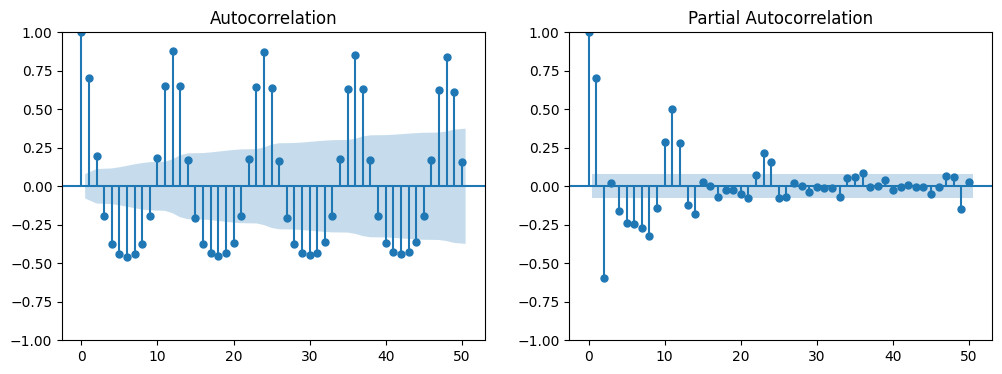

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df_month_sum["Q_m3_s"], ax=ax[0], lags=50)
plot_pacf(df_month_sum["Q_m3_s"], ax=ax[1], lags=50, method="ywm")
plt.show()

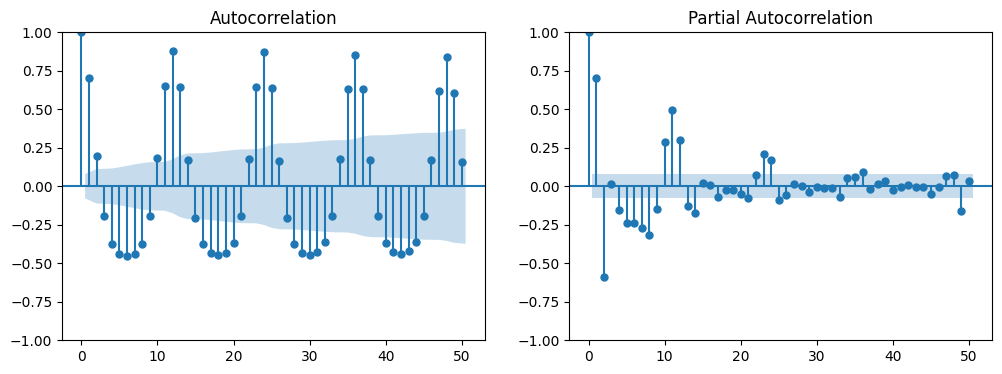

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(df_month_avg["Q_m3_s"], ax=ax[0], lags=50)
plot_pacf(df_month_avg["Q_m3_s"], ax=ax[1], lags=50, method="ywm")
plt.show()

# Splitting Train/Test

In [30]:
test_h = 24
start_train = df_month_start.iloc[:-test_h]
start_test = df_month_start.iloc[-test_h:]

In [31]:
sum_train = df_month_sum.iloc[:-test_h]
sum_test = df_month_sum.iloc[-test_h:]

In [32]:
avg_train = df_month_avg.iloc[:-test_h]
avg_test = df_month_avg.iloc[-test_h:]

# Auto ARIMA

In [40]:
start_auto_arima = pm.auto_arima(start_train['Q_m3_s'], m=12)
start_order = start_auto_arima.order
start_sorder = start_auto_arima.seasonal_order

In [41]:
sum_auto_arima = pm.auto_arima(sum_train['Q_m3_s'], m=12)
sum_order = sum_auto_arima.order
sum_sorder = sum_auto_arima.seasonal_order

In [42]:
avg_auto_arima = pm.auto_arima(avg_train['Q_m3_s'], m=12)
avg_order = avg_auto_arima.order
avg_sorder = avg_auto_arima.seasonal_order

# Fit Model

In [47]:
def fit_forecast(ts_train, steps, order, seasonal_order=None, exog_train=None, exog_test=None):
    mod = SARIMAX(ts_train, order=order,
                  seasonal_order=seasonal_order,
                  exog=exog_train,
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)
    fc = mod.forecast(steps=steps, exog=exog_test)
    return mod, fc

In [48]:
start_model, startfc = fit_forecast(start_train['Q_m3_s'],test_h, start_order, start_sorder)

In [49]:
sum_model, sumfc = fit_forecast(sum_train['Q_m3_s'],test_h, sum_order, sum_sorder)

In [50]:
avg_model, avgfc = fit_forecast(avg_train['Q_m3_s'],test_h, avg_order, avg_sorder)

# Plot Forecasts

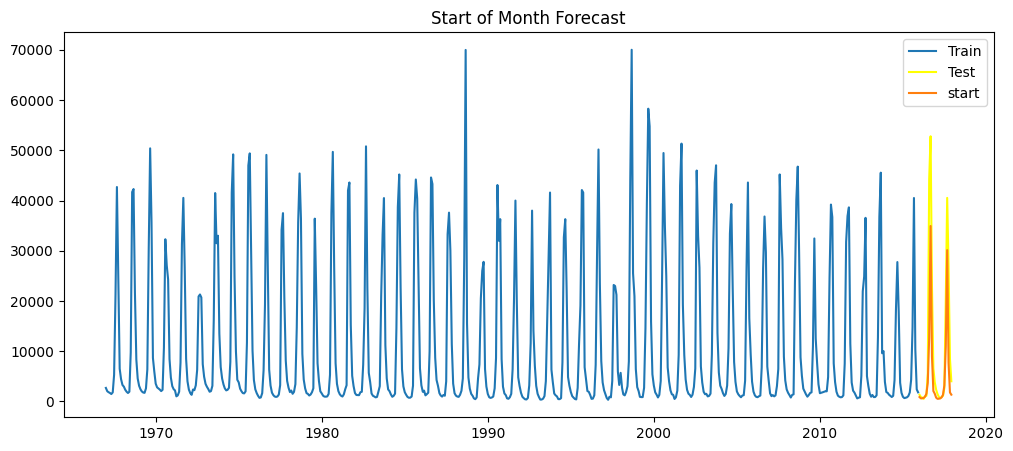

In [51]:
plt.figure(figsize=(12,5))
plt.plot(start_train.index, start_train["Q_m3_s"], label="Train")
plt.plot(start_test.index, start_test["Q_m3_s"], label="Test", color="yellow")
plt.plot(start_test.index, startfc, label="start")
plt.title("Start of Month Forecast")
plt.legend()
plt.show()

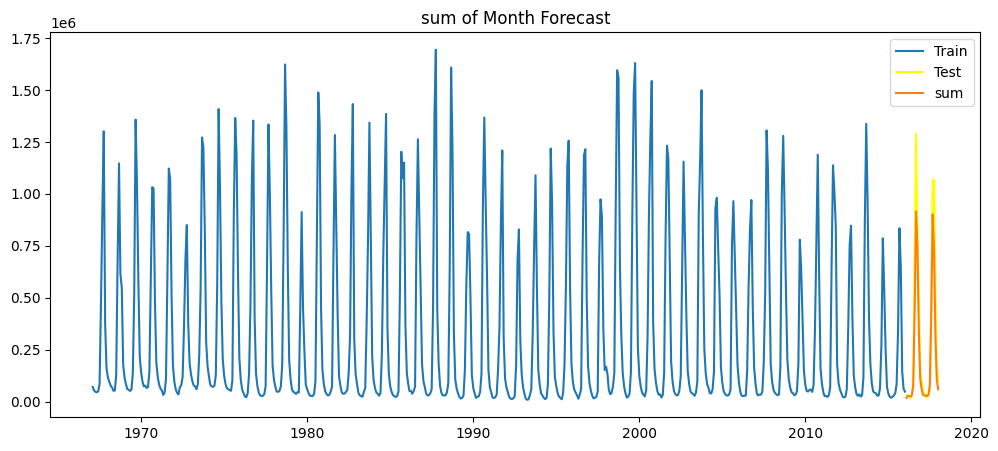

In [52]:
plt.figure(figsize=(12,5))
plt.plot(sum_train.index, sum_train["Q_m3_s"], label="Train")
plt.plot(sum_test.index, sum_test["Q_m3_s"], label="Test", color="yellow")
plt.plot(sum_test.index, sumfc, label="sum")
plt.title("sum of Month Forecast")
plt.legend()
plt.show()

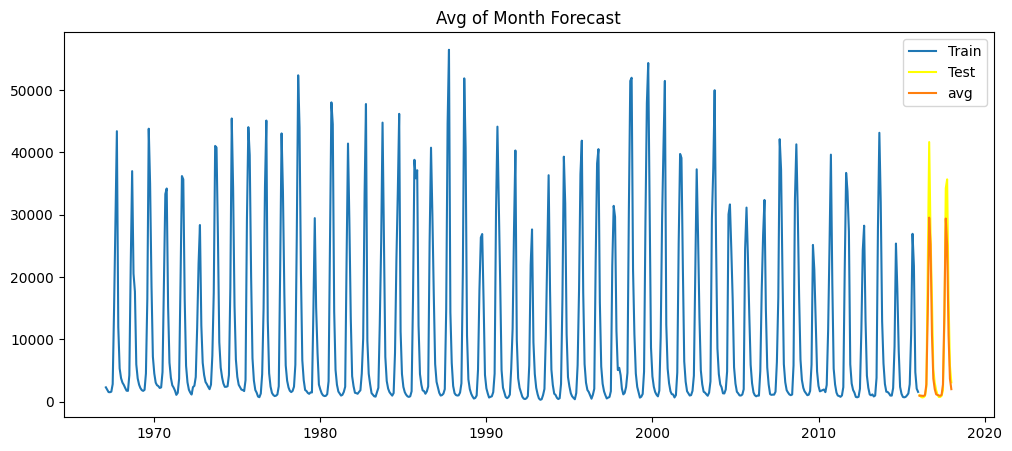

In [53]:
plt.figure(figsize=(12,5))
plt.plot(avg_train.index, avg_train["Q_m3_s"], label="Train")
plt.plot(avg_test.index, avg_test["Q_m3_s"], label="Test", color="yellow")
plt.plot(avg_test.index, avgfc, label="avg")
plt.title("Avg of Month Forecast")
plt.legend()
plt.show()

# Metrics

In [54]:
def metric(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = (np.abs((actual - pred) / actual)).mean()*100
    return rmse, mae, mape

In [58]:
res = {}
for name, m, fc in [
    ("Start", start_model, startfc)
]:
    rmse, mae, mape = metric(start_test["Q_m3_s"], fc)
    res[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "AIC": m.aic,
        "BIC": m.bic
    }

print(pd.DataFrame(res))

             Start
RMSE   9476.596218
MAE    5236.027079
MAPE     42.209854
AIC   12053.527739
BIC   12066.590849


In [59]:
res = {}
for name, m, fc in [
    ("Sum", sum_model, sumfc)
]:
    rmse, mae, mape = metric(sum_test["Q_m3_s"], fc)
    res[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "AIC": m.aic,
        "BIC": m.bic
    }

print(pd.DataFrame(res))

                Sum
RMSE  131523.503635
MAE    77262.962798
MAPE      26.640477
AIC    15136.247646
BIC    15179.509140


In [60]:
res = {}
for name, m, fc in [
    ("Avg", avg_model, avgfc)
]:
    rmse, mae, mape = metric(avg_test["Q_m3_s"], fc)
    res[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "AIC": m.aic,
        "BIC": m.bic
    }

print(pd.DataFrame(res))

               Avg
RMSE   4175.435523
MAE    2453.494988
MAPE     26.218991
AIC   11772.425043
BIC   11789.842523
